In [16]:
%reload_ext autoreload
%autoreload 2

#  import important libraries
# There are diifferent types of Qiskit Metal designs available- Design Planar,MultiPlanar,FlipChipDesign,etc. DesignPlanar is Metal class for a planar (2D) design, consisting of a single plane chip.
#  open GUI
#  if we disable the overwrite statement line, then we will need to delete a component before recreating it, thats why need to set it enabled.


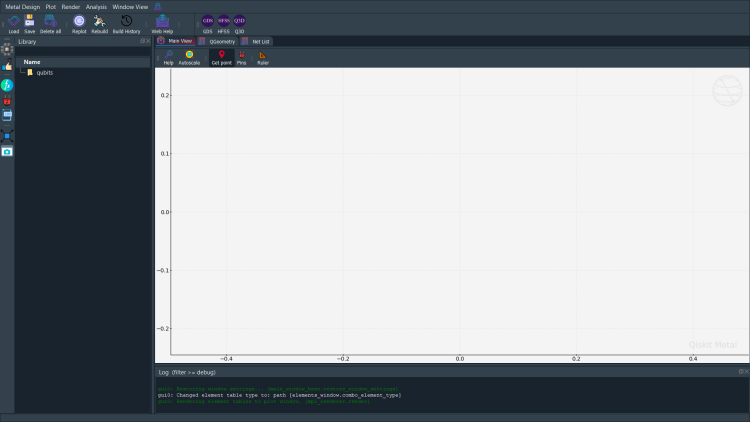

In [2]:
import numpy as np
from collections import OrderedDict

from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

design = designs.DesignPlanar()
gui = MetalGUI(design)
gui.screenshot()
design.overwrite_enabled = True

# Import some components that will be necessary for the design

In [3]:
from qiskit_metal.qlibrary.qubits.transmon_pocket_cl import TransmonPocketCL
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.launchpad_wb_coupled import LaunchpadWirebondCoupled

# Setup the design: modify the properties of Design Object

In [4]:
design.variables['cpw_width'] = '10 um'
design.variables['cpw_gap'] = '6 um'
design._chips['main']['size']['size_x'] = '9mm'
design._chips['main']['size']['size_y'] = '6.5mm'

# With the help of below code line we can check the available options for creating a transmon qubit

In [5]:
TransmonPocketCL.get_template_options(design)

{'pos_x': '0.0um',
 'pos_y': '0.0um',
 'orientation': '0.0',
 'chip': 'main',
 'layer': '1',
 'connection_pads': {},
 '_default_connection_pads': {'pad_gap': '15um',
  'pad_width': '125um',
  'pad_height': '30um',
  'pad_cpw_shift': '5um',
  'pad_cpw_extent': '25um',
  'cpw_width': 'cpw_width',
  'cpw_gap': 'cpw_gap',
  'cpw_extend': '100um',
  'pocket_extent': '5um',
  'pocket_rise': '65um',
  'loc_W': '+1',
  'loc_H': '+1'},
 'pad_gap': '30um',
 'inductor_width': '20um',
 'pad_width': '455um',
 'pad_height': '90um',
 'pocket_width': '650um',
 'pocket_height': '650um',
 'make_CL': True,
 'cl_gap': '6um',
 'cl_width': '10um',
 'cl_length': '20um',
 'cl_ground_gap': '6um',
 'cl_pocket_edge': '0',
 'cl_off_center': '50um',
 'hfss_wire_bonds': False,
 'q3d_wire_bonds': False,
 'hfss_inductance': '10nH',
 'hfss_capacitance': 0,
 'hfss_resistance': 0,
 'hfss_mesh_kw_jj': 7e-06,
 'q3d_inductance': '10nH',
 'q3d_capacitance': 0,
 'q3d_resistance': 0,
 'q3d_mesh_kw_jj': 7e-06,
 'gds_cell_name'

# We want to change the pad_width for these transmons, as well as define the 3 connection pads and chargeline.
# Apply the same modifications to all 4 transmons, so below line of code will create a dictionary object  transmon_options which stores a set of options for creating a transmon qubit 

In [6]:
transmon_options = dict(
    connection_pads=dict(
        a = dict(loc_W=+1, loc_H=-1, pad_width='70um', cpw_extend = '50um'), 
        b = dict(loc_W=-1, loc_H=-1, pad_width='125um', cpw_extend = '50um'),
        c = dict(loc_W=-1, loc_H=+1, pad_width='110um', cpw_extend = '50um')
    ),
    gds_cell_name='FakeJunction_01',
    cl_off_center = '-50um',
    cl_pocket_edge = '180'
)

# now create the 4 transmons by specifying the desired coordinates and orientations.

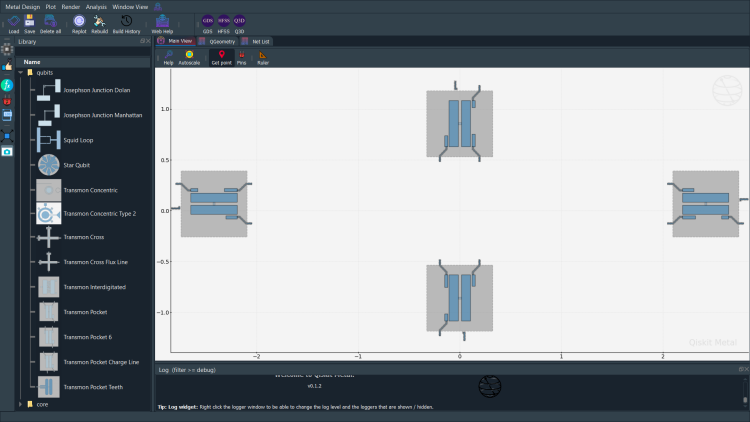

In [7]:
offset_tm = 69  #we the transmon slightly out of center-line

q1 = TransmonPocketCL(design, 'Q1', options = dict(
    pos_x='+2420um', pos_y=f'{offset_tm}um', **transmon_options))
q2 = TransmonPocketCL(design, 'Q2', options = dict(
    pos_x='0um', pos_y='-857.6um', orientation = '270', **transmon_options))
q3 = TransmonPocketCL(design, 'Q3', options = dict(
    pos_x='-2420um', pos_y=f'{offset_tm}um', orientation = '180', **transmon_options))
q4 = TransmonPocketCL(design, 'Q4', options = dict(
    pos_x='0um', pos_y='+857.6um', orientation = '90', **transmon_options))

gui.rebuild()
gui.autoscale()
gui.screenshot()

# this method is only used to get the options for creating a meandered transmission line 

In [8]:
RouteMeander.get_template_options(design)

{'chip': 'main',
 'layer': '1',
 'pin_inputs': {'start_pin': {'component': '', 'pin': ''},
  'end_pin': {'component': '', 'pin': ''}},
 'fillet': '0',
 'lead': {'start_straight': '0mm',
  'end_straight': '0mm',
  'start_jogged_extension': '',
  'end_jogged_extension': ''},
 'total_length': '7mm',
 'trace_width': 'cpw_width',
 'meander': {'spacing': '200um', 'asymmetry': '0um'},
 'snap': 'true',
 'prevent_short_edges': 'true',
 'hfss_wire_bonds': False,
 'q3d_wire_bonds': False}

# dictionary object cpw_options stores a set of options for creating transmission line 

In [9]:
fillet='99.99um'
cpw_options = Dict(
    lead=Dict(
        start_straight='100um',
        end_straight='250um'),
    fillet=fillet
    )


# We then want each transmission line to be connected to different pins and to have different lengths and asymmetry w.r.t their centerline.We redefine the RouteMeander signature by wrapping it into a convenient method named connect

In [10]:
def connect(cpw_name: str, pin1_comp_name: str, pin1_comp_pin: str, pin2_comp_name: str, pin2_comp_pin: str,
            length: str, asymmetry='0 um'):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        pin_inputs=Dict(
            start_pin=Dict(
                component=pin1_comp_name,
                pin=pin1_comp_pin),
            end_pin=Dict(
                component=pin2_comp_name,
                pin=pin2_comp_pin)),
        total_length=length)
    myoptions.update(cpw_options)
    myoptions.meander.asymmetry = asymmetry
    return RouteMeander(design, cpw_name, myoptions)

# define the meanders following the signature: connect(cpw_name, pin1_comp_name, pin1_comp_pin, pin2_comp_name, pin2_comp_pin, length, asymmetry)

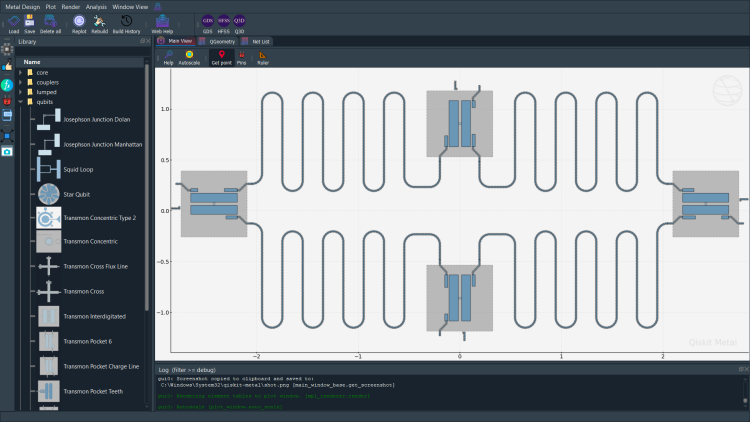

In [11]:
asym = 500
cpw1 = connect('cpw1', 'Q1', 'c', 'Q4', 'b', '9000um', f'-{asym-1.25*offset_tm}um')
cpw2 = connect('cpw2', 'Q3', 'b', 'Q4', 'c', '9000um', f'+{asym-1.25*offset_tm}um')
cpw3 = connect('cpw3', 'Q3', 'c', 'Q2', 'b', '9000um', f'-{asym+0.75*offset_tm}um')
cpw4 = connect('cpw4', 'Q1', 'b', 'Q2', 'c', '9000um', f'+{asym+0.75*offset_tm}um')

gui.rebuild()
gui.autoscale()
gui.screenshot()

# setup the launchpad location and orientation.

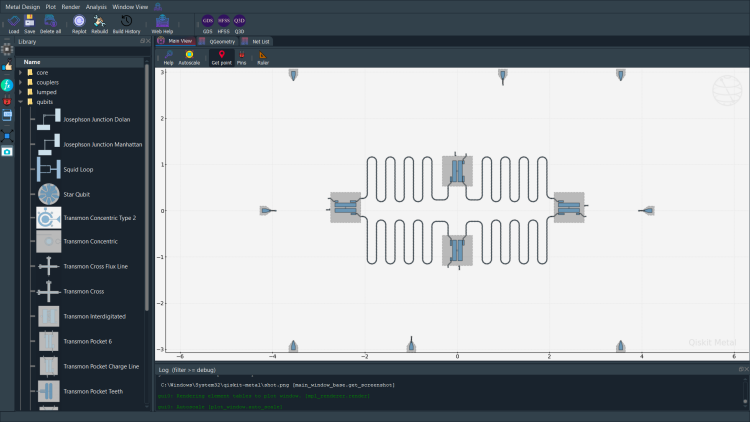

In [12]:
# V1 - Corners
p1_c = LaunchpadWirebond(design, 'P1_C', options = dict(pos_x='3545um', pos_y='2812um', orientation='270', lead_length='0um'))
p2_c = LaunchpadWirebond(design, 'P2_C', options = dict(pos_x='3545um', pos_y='-2812um', orientation='90', lead_length='0um'))
p3_c = LaunchpadWirebond(design, 'P3_C', options = dict(pos_x='-3545um', pos_y='-2812um', orientation='90', lead_length='0um'))
p4_c = LaunchpadWirebond(design, 'P4_C', options = dict(pos_x='-3545um', pos_y='2812um', orientation='270', lead_length='0um'))

# V2
p1_q = LaunchpadWirebondCoupled(design, 'P1_Q', options = dict(pos_x='4020um', pos_y='0', orientation='180', lead_length='30um'))
p2_q = LaunchpadWirebondCoupled(design, 'P2_Q', options = dict(pos_x='-990um', pos_y='-2812um', orientation='90', lead_length='30um'))
p3_q = LaunchpadWirebondCoupled(design, 'P3_Q', options = dict(pos_x='-4020um', pos_y='0', orientation='0', lead_length='30um'))
p4_q = LaunchpadWirebondCoupled(design, 'P4_Q', options = dict(pos_x='990um', pos_y='2812um', orientation='270', lead_length='30um'))

gui.rebuild()
gui.autoscale()
gui.screenshot()

# Route- First the V2 launchpads - Exchange Coupler Lines to Edges.
# Route- then the V1 launchpads - Chargelines to Corners.

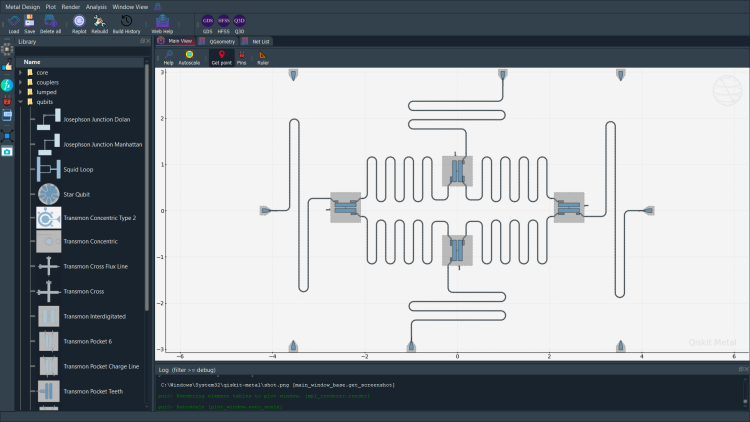

In [13]:
asym = 150
cpw_options = Dict(
    lead=Dict(
        start_straight='430um',
        end_straight='0um'),
    fillet=fillet
    )
ol1 = connect('ol1', 'Q1', 'a', 'P1_Q', 'tie', '8.6 mm', f'+{asym}um')
ol3 = connect('ol3', 'Q3', 'a', 'P3_Q', 'tie', '8.6 mm', f'+{asym}um')

asym = 200
cpw_options = Dict(
    lead=Dict(
        start_straight='535um',
        end_straight='0um'),
    fillet=fillet
    )
ol2 = connect('ol2', 'Q2', 'a', 'P2_Q', 'tie', '8.6 mm', f'+{asym}um')
ol4 = connect('ol4', 'Q4', 'a', 'P4_Q', 'tie', '8.6 mm', f'+{asym}um')

gui.rebuild()
gui.autoscale()
gui.screenshot()

# finally create the transmission lines between the corner launchpads and the qubit charge lines.



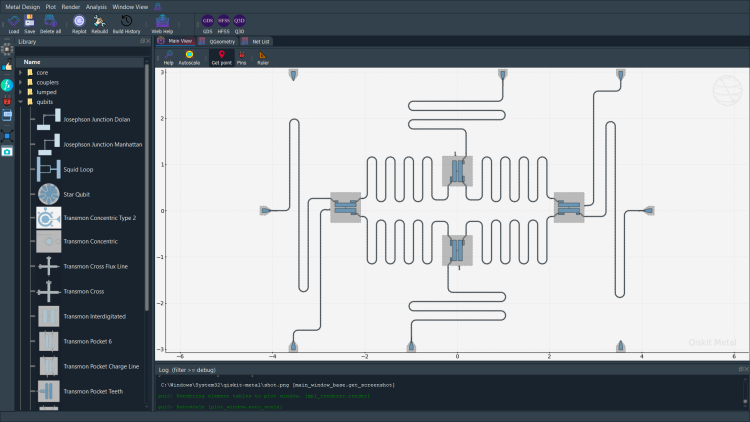

In [14]:
from collections import OrderedDict
jogsA_in = OrderedDict()
jogsA_in[0] = ["L", '200um']

options_line_cl1 = {'pin_inputs': 
            {'start_pin': {'component': 'Q1', 'pin': 'Charge_Line'}, 
             'end_pin': {'component': 'P1_C', 'pin': 'tie'}},
            'lead': {'start_straight': '120um', 'end_straight': '225um','start_jogged_extension': jogsA_in},
            'fillet': fillet
            }
cl1 = RouteAnchors(design, 'line_cl1', options_line_cl1)

options_line_cl3 = {'pin_inputs': 
            {'start_pin': {'component': 'Q3', 'pin': 'Charge_Line'}, 
             'end_pin': {'component': 'P3_C', 'pin': 'tie'}},
            'lead': {'start_straight': '120um', 'end_straight': '225um', 'start_jogged_extension': jogsA_in},
            'fillet': fillet
            }
cl3 = RouteAnchors(design, 'line_cl3', options_line_cl3)

gui.rebuild()
gui.autoscale()
gui.screenshot()

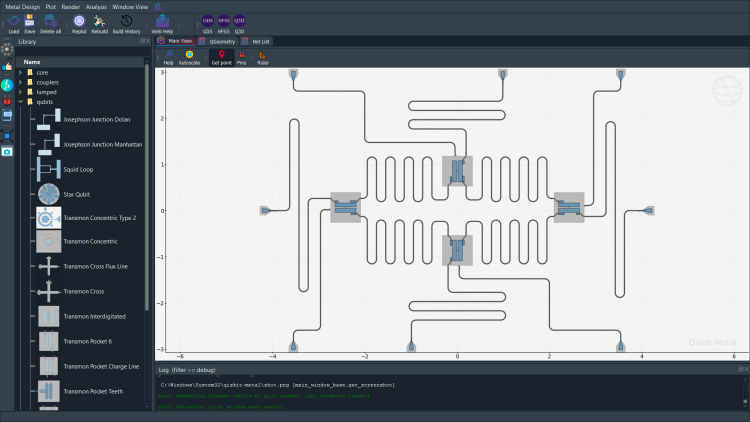

In [15]:
jogsB_in = OrderedDict()
jogsB_in[0] = ["L", '300um']

anchors2c = OrderedDict()
anchors2c[0] = np.array([2, -2.5])

options_line_cl2 = {'pin_inputs': 
            {'start_pin': {'component': 'Q2', 'pin': 'Charge_Line'}, 
             'end_pin': {'component': 'P2_C', 'pin': 'tie'}},
            'lead': {'start_straight': '200um', 'end_straight': '225um',
                     'start_jogged_extension': jogsB_in},
            'anchors': anchors2c,
            'fillet': fillet
            }

cl2 = RouteAnchors(design, 'line_cl2', options_line_cl2)

anchors4c = OrderedDict()
anchors4c[0] = np.array([-2, 2.5])

options_line_cl4 = {'pin_inputs': 
            {'start_pin': {'component': 'Q4', 'pin': 'Charge_Line'}, 
             'end_pin': {'component': 'P4_C', 'pin': 'tie'}},
            'lead': {'start_straight': '200um', 'end_straight': '225um',
                     'start_jogged_extension': jogsB_in},
            'anchors': anchors4c,
            'fillet': fillet
            }

cl4 = RouteAnchors(design, 'line_cl4', options_line_cl4)

gui.rebuild()
gui.autoscale()
gui.screenshot()